In [1]:
# @title 1. Setup and Configuration
# This cell handles imports and defines global configurations.

import os
import time
import copy
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
# NOTE: Adjust BATCH_SIZE if you encounter out-of-memory errors.
BATCH_SIZE = 64
EPOCHS_PRETRAIN = 50 # As requested
EPOCHS_LINEAR_EVAL = 50 # Number of epochs for linear evaluation
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-6
PROJECTION_DIM = 256 # Dimension of the projection head output
HIDDEN_DIM = 4096    # Hidden dimension in projector/predictor
MOMENTUM_BASE = 0.99 # Base momentum for target network EMA
NUM_WORKERS = 2 # Number of data loading workers
NUM_CLASSES = 4 # Dark, Green, Light, Medium coffee beans

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Path to save models/plots in the Kaggle environment
SAVE_DIR = "/kaggle/working/byol_coffee_results"
os.makedirs(SAVE_DIR, exist_ok=True)

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Using device: cuda


In [8]:
# @title 2. BYOL Data Augmentations and Loading for Coffee Beans (Corrected Path)
# This cell defines the data augmentation pipeline and loads the dataset.

# --- Data Augmentations ---
class CustomBYOLTransform:
    def __init__(self, size=224):
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])

        kernel_size = int(0.1 * size)
        if kernel_size % 2 == 0:
            kernel_size += 1

        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=kernel_size)], p=0.5),
            transforms.ToTensor(),
            normalize
        ])

    def __call__(self, x):
        return self.transform(x), self.transform(x)

# --- Custom Dataset for BYOL Pre-training ---
class BYOLImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if self.transform is not None:
            return self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

# --- Define Kaggle Data Paths (Corrected) ---
DATA_DIR = "/kaggle/input/coffee-bean-dataset-resized-224-x-224"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
# ---------------------------------------------

# --- Create Datasets and DataLoaders ---

# Dataset for BYOL self-supervised pre-training
train_dataset_byol = BYOLImageFolder(root=TRAIN_DIR, transform=CustomBYOLTransform())
train_loader_byol = DataLoader(train_dataset_byol, batch_size=BATCH_SIZE, shuffle=True,
                               num_workers=NUM_WORKERS, drop_last=True, pin_memory=True)

# Datasets for linear evaluation (using standard augmentations)
train_transform_eval = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform_eval = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset_eval = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform_eval)
test_dataset_eval = datasets.ImageFolder(root=TEST_DIR, transform=test_transform_eval)

train_loader_eval = DataLoader(train_dataset_eval, batch_size=BATCH_SIZE, shuffle=True,
                               num_workers=NUM_WORKERS, pin_memory=True)
test_loader_eval = DataLoader(test_dataset_eval, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=True)

print(f"BYOL pre-training dataset size: {len(train_dataset_byol)}")
print(f"Linear evaluation training dataset size: {len(train_dataset_eval)}")
print(f"Linear evaluation test dataset size: {len(test_dataset_eval)}")

BYOL pre-training dataset size: 1200
Linear evaluation training dataset size: 1200
Linear evaluation test dataset size: 400


In [10]:
# @title 3. BYOL Model Components
# This cell defines the encoder, projector, and predictor networks.

class BYOLResNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Use ResNet-50, which is well-suited for 224x224 images
        resnet = models.resnet50(weights=None)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        self.feature_dim = 2048

    def forward(self, x):
        return self.encoder(x).view(x.size(0), -1)

class ProjectionHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

class PredictionHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# Main BYOL Model
class BYOL(nn.Module):
    def __init__(self, encoder: BYOLResNet, projection_dim, hidden_dim):
        super().__init__()
        self.online_encoder = encoder
        self.online_projector = ProjectionHead(encoder.feature_dim, hidden_dim, projection_dim)
        self.online_predictor = PredictionHead(projection_dim, hidden_dim, projection_dim)
        self.target_encoder = copy.deepcopy(encoder)
        self.target_projector = copy.deepcopy(self.online_projector)

        for param in self.target_encoder.parameters():
            param.requires_grad = False
        for param in self.target_projector.parameters():
            param.requires_grad = False

    def forward(self, x1, x2):
        online_proj_out1 = self.online_projector(self.online_encoder(x1))
        online_pred_out1 = self.online_predictor(online_proj_out1)
        online_proj_out2 = self.online_projector(self.online_encoder(x2))
        online_pred_out2 = self.online_predictor(online_proj_out2)

        with torch.no_grad():
            target_proj_out1 = self.target_projector(self.target_encoder(x1))
            target_proj_out2 = self.target_projector(self.target_encoder(x2))

        return online_pred_out1, online_pred_out2, target_proj_out1, target_proj_out2

    def update_target_network(self, momentum):
        for online_param, target_param in zip(self.online_encoder.parameters(), self.target_encoder.parameters()):
            target_param.data = target_param.data * momentum + online_param.data * (1. - momentum)
        for online_param, target_param in zip(self.online_projector.parameters(), self.target_projector.parameters()):
            target_param.data = target_param.data * momentum + online_param.data * (1. - momentum)

# Instantiate the BYOL model
byol_encoder = BYOLResNet().to(DEVICE)
byol_model = BYOL(byol_encoder, PROJECTION_DIM, HIDDEN_DIM).to(DEVICE)

In [12]:
# @title 4. BYOL Loss Function
# This cell defines the custom BYOL loss.

def byol_loss(online_pred, target_proj):
    online_pred_norm = F.normalize(online_pred, dim=-1)
    target_proj_norm = F.normalize(target_proj, dim=-1)
    loss = 2 - 2 * (online_pred_norm * target_proj_norm).sum(dim=-1)
    return loss.mean()

In [16]:
# @title 5. Self-Supervised Pre-training Loop (Corrected)
# This cell contains the main training logic for BYOL.

def adjust_learning_rate(optimizer, init_lr, epoch, total_epochs):
    lr = init_lr * 0.5 * (1. + math.cos(math.pi * epoch / total_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def adjust_momentum(epoch, total_epochs, momentum_base):
    m = 1. - (1. - momentum_base) * (math.cos(math.pi * epoch / total_epochs) + 1) / 2
    return m

print("--- Starting BYOL Self-Supervised Pre-training ---\n")
optimizer = optim.AdamW(byol_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
pretrain_losses = []

for epoch in range(1, EPOCHS_PRETRAIN + 1):
    byol_model.train()
    total_loss = 0.0
    start_time = time.time()
    adjust_learning_rate(optimizer, LEARNING_RATE, epoch, EPOCHS_PRETRAIN)
    current_momentum = adjust_momentum(epoch, EPOCHS_PRETRAIN, MOMENTUM_BASE)

    for (x1, x2) in train_loader_byol:
        x1, x2 = x1.to(DEVICE), x2.to(DEVICE)
        optimizer.zero_grad()
        online_pred_out1, online_pred_out2, target_proj_out1, target_proj_out2 = byol_model(x1, x2)
        loss1 = byol_loss(online_pred_out1, target_proj_out2)
        loss2 = byol_loss(online_pred_out2, target_proj_out1)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        byol_model.update_target_network(current_momentum)
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader_byol)
    pretrain_losses.append(avg_loss)
    elapsed_time = time.time() - start_time
    
    # --- FIX: Correctly access the learning rate from the list of param_groups ---
    print(f"Pretrain Epoch {epoch}/{EPOCHS_PRETRAIN} | Loss: {avg_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f} | Momentum: {current_momentum:.4f} | Time: {elapsed_time:.1f}s")
    # -----------------------------------------------------------------------------

print("\n--- BYOL Self-Supervised Pre-training Finished ---\n")

# Save the pre-trained encoder weights with a descriptive name
encoder_path = os.path.join(SAVE_DIR, "byol_encoder_coffee.pth")
torch.save(byol_model.online_encoder.state_dict(), encoder_path)
print(f"Saved pre-trained encoder to {encoder_path}")

--- Starting BYOL Self-Supervised Pre-training ---

Pretrain Epoch 1/50 | Loss: 1.6898 | LR: 0.000300 | Momentum: 0.9900 | Time: 54.2s
Pretrain Epoch 2/50 | Loss: 1.3940 | LR: 0.000299 | Momentum: 0.9900 | Time: 52.7s
Pretrain Epoch 3/50 | Loss: 1.0887 | LR: 0.000297 | Momentum: 0.9901 | Time: 52.4s
Pretrain Epoch 4/50 | Loss: 0.8442 | LR: 0.000295 | Momentum: 0.9902 | Time: 52.7s
Pretrain Epoch 5/50 | Loss: 0.7437 | LR: 0.000293 | Momentum: 0.9902 | Time: 57.8s
Pretrain Epoch 6/50 | Loss: 0.7335 | LR: 0.000289 | Momentum: 0.9904 | Time: 56.2s
Pretrain Epoch 7/50 | Loss: 0.8029 | LR: 0.000286 | Momentum: 0.9905 | Time: 55.0s
Pretrain Epoch 8/50 | Loss: 0.8852 | LR: 0.000281 | Momentum: 0.9906 | Time: 54.3s
Pretrain Epoch 9/50 | Loss: 0.9009 | LR: 0.000277 | Momentum: 0.9908 | Time: 50.8s
Pretrain Epoch 10/50 | Loss: 0.9241 | LR: 0.000271 | Momentum: 0.9910 | Time: 53.8s
Pretrain Epoch 11/50 | Loss: 0.9092 | LR: 0.000266 | Momentum: 0.9911 | Time: 54.0s
Pretrain Epoch 12/50 | Loss: 0.89

In [17]:
# @title 6. Linear Evaluation (Downstream Task)
# This cell defines a linear classifier and evaluates the pre-trained encoder.

class LinearClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

print("\n--- Starting Linear Evaluation ---\n")

# Load the pre-trained encoder
pretrained_encoder = BYOLResNet().to(DEVICE)
encoder_path = os.path.join(SAVE_DIR, "byol_encoder_coffee.pth")
pretrained_encoder.load_state_dict(torch.load(encoder_path))
for param in pretrained_encoder.parameters():
    param.requires_grad = False

# Attach a new linear classifier head with the correct number of classes
classifier = LinearClassifier(pretrained_encoder.feature_dim, num_classes=NUM_CLASSES).to(DEVICE)

# Training setup
optimizer_eval = optim.Adam(classifier.parameters(), lr=LEARNING_RATE)
criterion_eval = nn.CrossEntropyLoss()
linear_eval_train_losses = []
linear_eval_test_accuracies = []

for epoch in range(1, EPOCHS_LINEAR_EVAL + 1):
    classifier.train()
    total_loss = 0.0
    start_time = time.time()
    for images, labels in train_loader_eval:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer_eval.zero_grad()
        with torch.no_grad():
            features = pretrained_encoder(images)
        outputs = classifier(features)
        loss = criterion_eval(outputs, labels)
        loss.backward()
        optimizer_eval.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader_eval)
    linear_eval_train_losses.append(avg_train_loss)

    # Evaluation on test set
    classifier.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader_eval:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            features = pretrained_encoder(images)
            outputs = classifier(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    linear_eval_test_accuracies.append(accuracy)
    elapsed_time = time.time() - start_time
    print(f"Linear Eval Epoch {epoch}/{EPOCHS_LINEAR_EVAL} | Train Loss: {avg_train_loss:.4f} | Test Acc: {accuracy:.2f}% | Time: {elapsed_time:.1f}s")

print("\n--- Linear Evaluation Finished ---\n")

# Train a randomly initialized encoder + classifier as a baseline
print("\n--- Training Baseline (Randomly Initialized Encoder) ---\n")
random_encoder = BYOLResNet().to(DEVICE)
random_classifier = LinearClassifier(random_encoder.feature_dim, num_classes=NUM_CLASSES).to(DEVICE)
random_model = nn.Sequential(random_encoder, random_classifier).to(DEVICE)
optimizer_random = optim.Adam(random_model.parameters(), lr=LEARNING_RATE)
criterion_random = nn.CrossEntropyLoss()
random_eval_test_accuracies = []

for epoch in range(1, EPOCHS_LINEAR_EVAL + 1):
    random_model.train()
    for images, labels in train_loader_eval:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer_random.zero_grad()
        outputs = random_model(images)
        loss = criterion_random(outputs, labels)
        loss.backward()
        optimizer_random.step()

    random_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader_eval:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = random_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    random_eval_test_accuracies.append(accuracy)
    if epoch % 10 == 0 or epoch == EPOCHS_LINEAR_EVAL:
        print(f"Random Baseline Eval Epoch {epoch}/{EPOCHS_LINEAR_EVAL} | Test Acc: {accuracy:.2f}%")

print("\n--- Random Baseline Training Finished ---\n")


--- Starting Linear Evaluation ---

Linear Eval Epoch 1/50 | Train Loss: 0.9772 | Test Acc: 39.50% | Time: 8.3s
Linear Eval Epoch 2/50 | Train Loss: 0.7560 | Test Acc: 38.75% | Time: 7.7s
Linear Eval Epoch 3/50 | Train Loss: 0.7068 | Test Acc: 36.25% | Time: 8.2s
Linear Eval Epoch 4/50 | Train Loss: 0.6998 | Test Acc: 34.25% | Time: 8.7s
Linear Eval Epoch 5/50 | Train Loss: 0.6213 | Test Acc: 35.50% | Time: 8.4s
Linear Eval Epoch 6/50 | Train Loss: 0.6328 | Test Acc: 37.50% | Time: 8.3s
Linear Eval Epoch 7/50 | Train Loss: 0.6607 | Test Acc: 34.25% | Time: 7.8s
Linear Eval Epoch 8/50 | Train Loss: 0.6631 | Test Acc: 34.25% | Time: 7.9s
Linear Eval Epoch 9/50 | Train Loss: 0.6253 | Test Acc: 37.00% | Time: 7.7s
Linear Eval Epoch 10/50 | Train Loss: 0.6093 | Test Acc: 39.25% | Time: 7.6s
Linear Eval Epoch 11/50 | Train Loss: 0.6098 | Test Acc: 37.50% | Time: 7.8s
Linear Eval Epoch 12/50 | Train Loss: 0.6072 | Test Acc: 33.25% | Time: 7.9s
Linear Eval Epoch 13/50 | Train Loss: 0.6290 | T

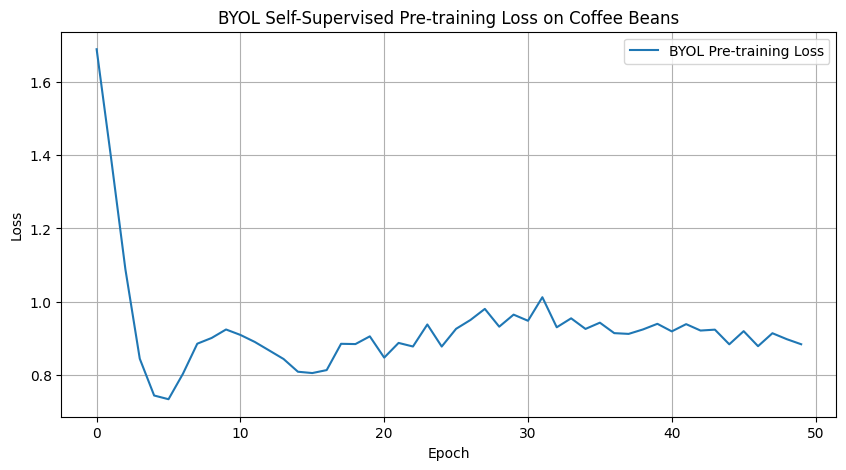

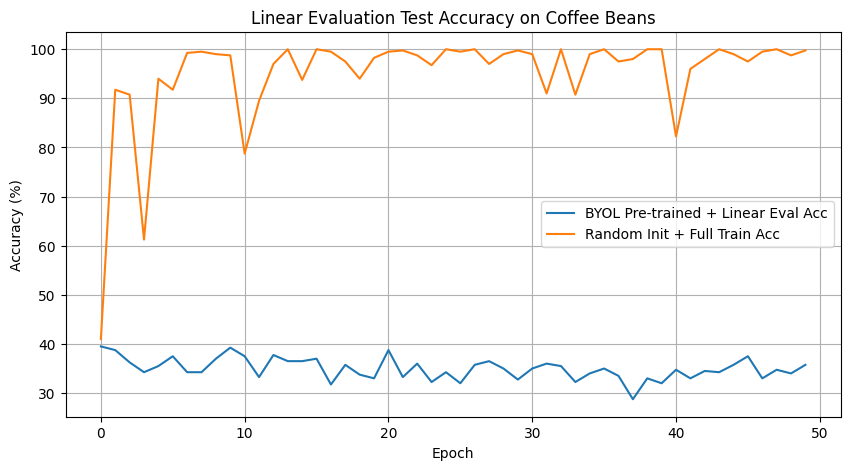


--- Visualizing Embedding Space with t-SNE ---

Running t-SNE on 400 embeddings...


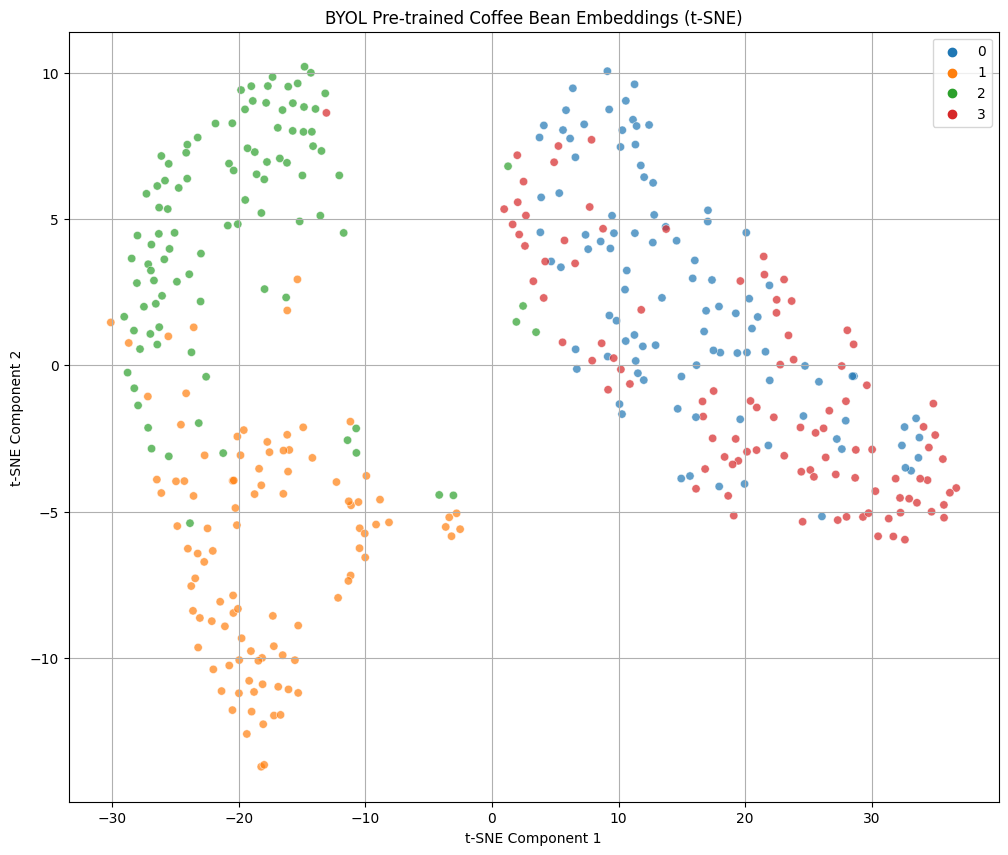

In [20]:
# @title 7. Visualization of Impact (Corrected)
# This cell provides code to visualize the training loss and embedding space.

# --- Loss Curve ---
plt.figure(figsize=(10, 5))
plt.plot(pretrain_losses, label='BYOL Pre-training Loss')
plt.title('BYOL Self-Supervised Pre-training Loss on Coffee Beans')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(SAVE_DIR, "byol_pretrain_loss_coffee.png"))
plt.show()

# --- Accuracy Comparison ---
plt.figure(figsize=(10, 5))
plt.plot(linear_eval_test_accuracies, label='BYOL Pre-trained + Linear Eval Acc')
plt.plot(random_eval_test_accuracies, label='Random Init + Full Train Acc')
plt.title('Linear Evaluation Test Accuracy on Coffee Beans')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(SAVE_DIR, "linear_eval_accuracy_coffee.png"))
plt.show()

# --- Embedding Space Visualization (t-SNE) ---
print("\n--- Visualizing Embedding Space with t-SNE ---\n")

# --- FIX: Use the smaller of 1000 or the actual dataset size ---
num_samples_tsne = min(1000, len(test_dataset_eval))
# -----------------------------------------------------------------

# Use a subset of the test set for t-SNE
subset_indices = np.random.choice(len(test_dataset_eval), num_samples_tsne, replace=False)
subset_dataset_eval = torch.utils.data.Subset(test_dataset_eval, subset_indices)
subset_loader_eval = DataLoader(subset_dataset_eval, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

pretrained_encoder.eval()
embeddings = []
labels = []

with torch.no_grad():
    for images, targets in subset_loader_eval:
        images = images.to(DEVICE)
        features = pretrained_encoder(images)
        embeddings.append(features.cpu().numpy())
        labels.append(targets.cpu().numpy())

embeddings = np.vstack(embeddings)
labels = np.concatenate(labels)

print(f"Running t-SNE on {embeddings.shape[0]} embeddings...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)

# Plotting the t-SNE results
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
    hue=labels, palette=sns.color_palette("tab10", NUM_CLASSES),
    legend='full', alpha=0.7
)
plt.title('BYOL Pre-trained Coffee Bean Embeddings (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.savefig(os.path.join(SAVE_DIR, "byol_embeddings_tsne_coffee.png"))
plt.show()